In [1]:
import collections
import copy
import json
import os
import random
import time
import math

import numpy as np
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
# Environment definitions
EMPTY = 0
WALL = -1
START = 1
TYPE = {" ": EMPTY, "#": WALL, "S": START}
VIEW = {v: k for k, v in TYPE.items()}
VIEW[EMPTY] = " "
VIEW[START] = " "

all_config = {
             1: ( "##########\\"
                + "#        #\\"
                + "# ###### #\\"
                + "#    #   #\\"
                + "#    #   #\\"
                + "# ##### ##\\"
                + "#    #   #\\"
                + "#    #   #\\"
                + "#S   #   #\\"
                + "##########\\"),
    
             2: ( "##########\\"
                + "#        #\\"
                + "#        #\\"
                + "#        #\\"
                + "#        #\\"
                + "#        #\\"
                + "#        #\\"
                + "#        #\\"
                + "#S       #\\"
                + "##########\\"),

             3: ( "##########\\"
                + "#        #\\"
                + "#        #\\"
                + "#  ### ###\\"
                + "#    #   #\\"
                + "#    #   #\\"
                + "#  ### ###\\"
                + "#    #   #\\"
                + "#S   #   #\\"
                + "##########\\"),
    
             4: ( "##########\\"
                + "#        #\\"
                + "#        #\\"
                + "# ###### #\\"
                + "#    #   #\\"
                + "#    #   #\\"
                + "# ###### #\\"
                + "#    #   #\\"
                + "#S   #   #\\"
                + "##########\\"),
    
             5: ( "##########\\"
                + "#        #\\"
                + "#        #\\"
                + "# ###### #\\"
                + "#   ##   #\\"
                + "#   ##   #\\"
                + "# ###### #\\"
                + "#   ##   #\\"
                + "#S  ##   #\\"
                + "##########\\"),
                 
             6: ( "##########\\"
                + "#        #\\"
                + "#        #\\"
                + "#  ### ###\\"
                + "#    #   #\\"
                + "#    #   #\\"
                + "#  ### ###\\"
                + "#    #   #\\"
                + "#S   #   #\\"
                + "##########\\")
}

mapconfig = all_config[6]

if mapconfig.endswith("\\"):
    mapconfig = mapconfig[:-1]
config = mapconfig.split("\\")
config_size = np.array([len(c) for c in config])
grid_size = len(config_size)
assert np.all(config_size == config_size[0])
maze_map = np.zeros((grid_size, grid_size))
for h in range(grid_size):
    for w in range(grid_size):
        maze_map[h, w] = TYPE[config[h][w]]
print(maze_map)

def set_rfunc(rfunc):
    for h in range(grid_size):
        for w in range(grid_size):
            if maze_map[w, h] == WALL:
                rfunc[w, h] = 0.0
    return rfunc

num_actions = 4
mb_size = 32
num_states = grid_size ** 2

[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0. -1. -1. -1.  0. -1. -1. -1.]
 [-1.  0.  0.  0.  0. -1.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0. -1.  0.  0.  0. -1.]
 [-1.  0.  0. -1. -1. -1.  0. -1. -1. -1.]
 [-1.  0.  0.  0.  0. -1.  0.  0.  0. -1.]
 [-1.  1.  0.  0.  0. -1.  0.  0.  0. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


In [4]:
def get_obs(state):
  return np.eye(num_states)[state]

def get_rc(state):
  row = state//grid_size
  col = state % grid_size
  return row, col

def get_s(row, col):
  return row*grid_size+col

def reset(size=mb_size, start_state=None):        
    if start_state is not None:
        state = start_state * np.ones([size], dtype=np.int)
    elif np.sum(np.where(maze_map == START)) != 0:
        row, col = np.where(maze_map == START)
        ind = np.random.choice(np.arange(col.shape[0]), size=size)
        state = get_s(row[ind], col[ind])
    else:
        nowall = np.array([x for x in np.arange(num_states) if maze_map[get_rc(x)] != WALL])
        state = np.random.choice(nowall, size=size)
    return state

def step(state, action):
    row, col = get_rc(state)
    # a0:up
    new_r = np.where(action == 0, row - 1, row)
    new_r = np.where(maze_map[new_r, col] != WALL, new_r, row)
    # a1:left
    new_c = np.where(action == 1, col - 1, col)
    new_c = np.where(maze_map[new_r, new_c] != WALL, new_c, col)
    # a2:down
    old_r = new_r
    new_r = np.where(action == 2, new_r + 1, new_r)
    new_r = np.where(maze_map[new_r, new_c] != WALL, new_r, old_r)
    # a3:right
    old_c = new_c
    new_c = np.where(action == 3, new_c + 1, new_c)
    new_c = np.where(maze_map[new_r, new_c] != WALL, new_c, old_c)
    # clip
    new_r[new_r >= grid_size] = grid_size - 1
    new_r[new_r < 0] = 0
    new_c[new_c >= grid_size] = grid_size - 1
    new_c[new_c < 0] = 0
    return get_s(new_r, new_c)

In [5]:
# Algorithm training code
# The code is consistent with code used for other domains
def soft_update(target, source, tau):
    for t, s in zip(target.parameters(), source.parameters()):
        t.data.copy_(t.data * (1.0 - tau) + s.data * tau)


def hard_update(target, source):
    target.load_state_dict(source.state_dict())


def grad_false(network):
    for param in network.parameters():
        param.requires_grad = False


class THRMS(object):
    def __init__(self, epsilon=1e-4, shape=(1,)):
        self.M = torch.zeros(shape).to(device)
        self.S = torch.ones(shape).to(device)
        self.n = epsilon

    def __call__(self, x):
        bs = x.size(0)
        delta = torch.mean(x, dim=0) - self.M
        new_M = self.M + delta * bs / (self.n + bs)
        new_S = (self.S * self.n + torch.var(x, dim=0) * bs + torch.square(delta) * self.n * bs / (self.n + bs)) / (self.n + bs)

        self.M = new_M
        self.S = new_S
        self.n += bs

        return self.M, self.S


thrms = THRMS()


def compute_apt_reward(source, target, args):
    try:  # torch if allowed
        b1, b2, n = source.size(0), target.size(0), args.en_num
        # (b1, 1, n*c) - (1, b2, n*c) -> (b1, 1, n, c) - (1, b2, n, c) -> (b1, b2, n, c) -> (b1, b2, n)
        sim_matrix = torch.norm(source[:, None, :].view(b1, 1, n, -1) - target[None, :, :].view(1, b2, n, -1), dim=-1, p=2)
        reward, _ = sim_matrix.topk(args.knn_k, dim=1, largest=False, sorted=True)  # (b1, k, n)
    except:  # numpy if cuda OOM
        source, target = source.cpu().numpy(), target.cpu().numpy()
        b1, b2, n = source.shape[0], target.shape[0], args.en_num
        # (b1, 1, n*c) - (1, b2, n*c) -> (b1, 1, n, c) - (1, b2, n, c) -> (b1, b2, n, c) -> (b1, b2, n)
        sim_matrix = np.linalg.norm(source[:, None, :].reshape(b1, 1, n, -1) - target[None, :, :].reshape(1, b2, n, -1), axis=-1, ord=2)
        reward = np.partition(sim_matrix, args.knn_k, axis=1)[:, : args.knn_k, :]  # (b1, k, n)
        reward = torch.FloatTensor(reward).to(device)

    if not args.knn_avg:  # only keep k-th nearest neighbor
        reward = reward[:, 0, :]
        reward = reward.reshape(-1, 1)  # (b1 * n, 1)
        moving_mean, moving_std = thrms(reward)
        reward = reward / moving_std
        reward = torch.maximum(reward - args.knn_clip, torch.zeros_like(reward).to(device))
        reward = reward.reshape((b1, n))  # (b1, n)
    else:  # average over all k nearest neighbors
        reward = reward.reshape(-1, 1)  # (b1 * k *n, 1)
        moving_mean, moving_std = thrms(reward)
        reward = reward / moving_std
        reward = torch.maximum(reward - args.knn_clip, torch.zeros_like(reward).to(device))
        reward = reward.reshape((b1, args.knn_k, n))  # (b1, k, n)
        reward = reward.mean(dim=1)  # (b1, n)
    reward = torch.log(reward + 1.0)
    reward = reward.reshape(b1, -1).mean(dim=1).unsqueeze(1)  # (b1, n) -> (b1, 1)
    return reward


class Buffer(object):
    def __init__(self, args):
        self.ptr = 0
        self.size = 0
        self.max_size = args.max_size
        self.knn_bs = args.knn_bs
        self.tgt = args.tgt
        self.num_states = args.num_states

        self.state = np.empty((args.max_size, args.batch_env_size), dtype=np.int)
        self.action = np.empty((args.max_size, args.batch_env_size), dtype=np.int)
        self.next_state = np.empty((args.max_size, args.batch_env_size), dtype=np.int)
        self.reward = np.empty((args.max_size, args.batch_env_size), dtype=np.float32)
        
        self.ptr2 = 0
        self.size2 = 0
        self.max_size2 = int(1e5)
        self.state2 = np.empty((self.max_size2, args.batch_env_size), dtype=np.int)
        self.next_state2 = np.empty((self.max_size2, args.batch_env_size), dtype=np.int)

    def add(self, state, action, next_state, reward):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        self.state2[self.ptr2] = state
        self.next_state2[self.ptr2] = next_state
        
        self.ptr2 = (self.ptr2 + 1) % self.max_size2
        self.size2 = min(self.size2 + 1, self.max_size2)

    def sample(self, batch_size):
        if self.tgt == "i":
            ind = np.random.choice(self.size, size=batch_size, replace=False) if 0 < batch_size <= self.size else np.arange(self.size)
            next_state = self.next_state[ind]
        elif self.tgt == "s":
            ind = np.random.choice(self.size, size=batch_size, replace=False) if 0 < batch_size <= self.size else np.arange(self.size)
            tgt_ind = np.arange(self.size2)
            tgt_ind = np.random.choice(self.size2, size=self.knn_bs, replace=False) if 0 < self.knn_bs <= self.size2 else np.arange(self.size2)
            next_state = self.next_state2[tgt_ind]
        return (
            F.one_hot(torch.LongTensor(self.state[ind].reshape(-1)), self.num_states).float().to(device),
            torch.LongTensor(self.action[ind]).reshape(-1, 1).to(device),
            F.one_hot(torch.LongTensor(self.next_state[ind]).reshape(-1), self.num_states).float().to(device),
            torch.FloatTensor(self.reward[ind].reshape(-1, 1)).to(device),
            F.one_hot(torch.LongTensor(next_state.reshape(-1)), self.num_states).float().to(device),
        )


class Critic(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.fc_v = nn.Sequential(nn.Linear(args.num_states, args.critic_hs), nn.ReLU(), nn.Linear(args.critic_hs, args.critic_hs), nn.ReLU(), nn.Linear(args.critic_hs, args.num_actions))

    def forward(self, state):
        q = self.fc_v(state) # (b, a)
        return q


class Algo(object):
    def __init__(self, args):
        self.critic = Critic(args).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=args.lr)
        self.critic_target = Critic(args).to(device).eval()
        hard_update(self.critic_target, self.critic)
        grad_false(self.critic_target)

        self.action_range = args.action_range
        self.total_it = 0
        self.epsilon = args.epsilon

    def select_action(self, state, stochastic):
        state = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            current_Q = self.critic(state)
            action = torch.argmax(current_Q, -1).long()
            action = action.clamp(*self.action_range)
            action = action.cpu().data.numpy().flatten()
            if stochastic:
                rand_action = np.random.randint(self.action_range[0], self.action_range[1] + 1, size=state.size(0)) 
                action = np.where(np.random.rand(state.size(0)) > self.epsilon, action, rand_action)
        return action

    def apt_reward(self, next_state, next_state_2, t, args):
        reward = compute_apt_reward(next_state, next_state_2, args)
        return reward

    def train(self, buffer, t, args, ft=False):
        self.total_it += 1

        # optimize critic
        state, action, next_state, reward, next_state_2 = buffer.sample(args.batch_size)
        if not ft:
            reward = self.apt_reward(next_state, next_state_2, t, args) # (b, 1)

        with torch.no_grad():
            next_action = self.critic(next_state).argmax(-1).view(-1, 1).long()  # (b, a) -> (b, 1)
            target_Q = self.critic_target(next_state).gather(-1, next_action).view(-1, 1).long() # (b, 1)
            target_Q = reward + args.gamma * target_Q  # (b, 1) + (b, 1)

        current_Q = self.critic(state).gather(-1, action).squeeze(-1) # (b, a) -> (b, 1)
        critic_loss = F.mse_loss(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_it % args.target_update_freq == 0:
            soft_update(self.critic_target, self.critic, args.tau)
        
        # you can using contrastive representation or vae but 
        # here using the raw one-shot features for simplicity
        sfeat_loss = torch.zeros(1).to(device)
            
        return critic_loss.detach().item(), sfeat_loss.detach().item()

In [6]:
class Args:
    max_size = 40
    max_timesteps = int(3e4) + 1
    enable_cudnn = False
    max_epilen = 40
    seed = 1
    lr = 1e-4
    batch_size = -1
    start_timesteps = 0
    critic_hs = 100
    gamma = 0.95
    tgt = "i" # knn target sampling."i": current mini-batch, "s": sample another mini-batch
    batch_env_size = mb_size
    epsilon = 0.1
    en_num = 1
    knn_bs = 256 # sampling batch size when tgt = "s"
    knn_avg = True # average the top k nns
    knn_k = 16 # top k of nearest neighbors
    knn_clip = 0.00025 # nearest neighbor clipping
    target_update_freq = 1 # no ema target net
    tau = 1.0 # no ema target net for simplicity
    
args = Args()
args.num_states = num_states
args.num_actions = num_actions
args.action_range = [0, args.num_actions - 1]

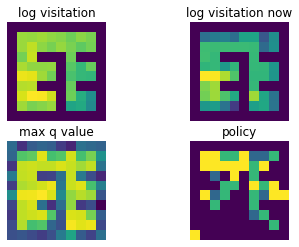

100%|██████████| 30001/30001 [17:25<00:00, 28.69it/s]


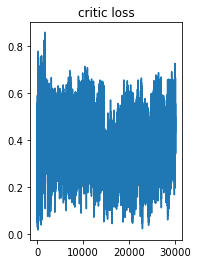

In [7]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = args.enable_cudnn
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

algo = Algo(args)
buffer = Buffer(args)

state = reset()
state_visit = np.ones([num_states])
cur_visit = np.ones([num_states])
critic_hist, sfeat_hist = [], []

for t in trange(1, args.max_timesteps + 1):
    for _ in range(args.max_epilen):
        action = algo.select_action(np.eye(args.num_states, dtype=np.int)[state], stochastic=True)
        next_state = step(state, action)
        buffer.add(state, action, next_state, 0.)
        state = next_state

        visit, count = np.unique(state, return_counts=True)
        cur_visit[visit] += count
        state_visit[visit] += count

    state = reset()
    
    cur_critic_loss, cur_sfeat_loss = algo.train(buffer, t, args)
    critic_hist.append(cur_critic_loss)
    sfeat_hist.append(cur_sfeat_loss)
    
    plt_freq = 100
    if t % plt_freq == 1:
        print(action)
        all_state = torch.FloatTensor(np.eye(num_states)[np.arange(num_states)]).to(device)
        with torch.no_grad():
            per_state_q = algo.critic(all_state)
            per_state_q = per_state_q.cpu().numpy()

        max_value_img = np.mean(per_state_q, -1).reshape([grid_size, grid_size])
        policy = np.argmax(per_state_q, -1)

        clear_output(wait=True)
        plt.figure(0)
        plt.subplot(221)
        plt.title('log visitation')
        plt.axis('off')
        plt.imshow(np.log(state_visit.reshape([grid_size, grid_size])), interpolation='none', aspect='equal')
        plt.subplot(222)
        plt.title('log visitation now')
        plt.axis('off')
        plt.imshow(np.log(cur_visit.reshape([grid_size, grid_size])), interpolation='none', aspect='equal')
        plt.subplot(223)
        plt.title('max q value')
        plt.axis('off')
        plt.imshow(max_value_img, interpolation='none', aspect='equal')
        plt.subplot(224)
        plt.title('policy')
        plt.axis('off')
        plt.imshow(policy.reshape([grid_size, grid_size]), interpolation='none', aspect='equal')
        plt.show()
        cur_visit = np.ones([num_states])
        
plt.subplot(121)
plt.title("critic loss")
plt.plot(critic_hist)

In [8]:
saved_algo = copy.deepcopy(algo)

In [55]:
# fine-tuning on a random reward function
algo = copy.deepcopy(saved_algo)
algo.critic_optimizer = torch.optim.Adam(algo.critic.parameters(), lr= 3e-4)
buffer = Buffer(args)

In [40]:
# specify a random reward function
r = np.zeros([grid_size, grid_size])
num_boxes = 4
box_size = 2
for _ in range(num_boxes):
    box_c = np.random.randint(grid_size-box_size)
    box_r = np.random.randint(grid_size-box_size)
    r[box_r: box_r+box_size, box_c: box_c+box_size] += 1.0
r = set_rfunc(r)
r = np.reshape(r, [num_states])

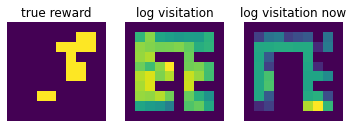

100%|██████████| 150/150 [00:22<00:00,  6.58it/s]


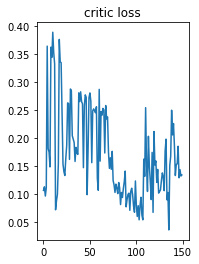

In [56]:
state = reset()
state_visit = np.ones([num_states])
cur_visit = np.ones([num_states])
critic_hist, sfeat_hist = [], []

for t in trange(1, 151):
    for _ in range(args.max_epilen):
        action = algo.select_action(np.eye(args.num_states, dtype=np.int)[state], stochastic=True)
        next_state = step(state, action)
        reward = r[next_state]
        buffer.add(state, action, next_state, reward)
        state = next_state
        visit, count = np.unique(state, return_counts=True)
        cur_visit[visit] += count
        state_visit[visit] += count
    state = reset()
    cur_critic_loss, cur_sfeat_loss = algo.train(buffer, t, args, ft=True) # fine-tuning
    critic_hist.append(cur_critic_loss)
    sfeat_hist.append(cur_sfeat_loss)

    clear_output(wait=True)
    plt.figure(0)
    plt.subplot(131)
    plt.title('true reward')
    plt.axis('off')
    plt.imshow(r.reshape([grid_size, grid_size]), interpolation='none', aspect='equal')
    plt.subplot(132)
    plt.title('log visitation')
    plt.axis('off')
    plt.imshow(np.log(state_visit.reshape([grid_size, grid_size])), interpolation='none', aspect='equal')
    plt.subplot(133)
    plt.title('log visitation now')
    plt.axis('off')
    plt.imshow(np.log(cur_visit.reshape([grid_size, grid_size])), interpolation='none', aspect='equal')
    plt.show()
    cur_visit = np.ones([num_states])

plt.subplot(121)
plt.title("critic loss")
plt.plot(critic_hist)

100%|██████████| 40/40 [00:00<00:00, 1536.26it/s]


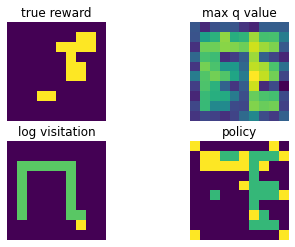

In [57]:
# visualization for random reward function
all_state = torch.FloatTensor(np.eye(num_states)[np.arange(num_states)]).to(device)
with torch.no_grad():
    per_state_q = algo.critic(all_state)
    per_state_q = per_state_q.cpu().numpy()
    
max_value_img = np.mean(per_state_q, -1).reshape([grid_size, grid_size])
policy = np.argmax(per_state_q, -1)
state_visit = np.ones([num_states])
state = reset(size=10000)
for t in trange(args.max_epilen):
    state = step(state, policy[state])
    visit, count = np.unique(state, return_counts=True)
    state_visit[visit] += count

plt.figure(0)
plt.subplot(221)
plt.title('true reward')
plt.axis('off')
plt.imshow(r.reshape([grid_size, grid_size]), interpolation='none', aspect='equal')
plt.subplot(222)
plt.title('max q value')
plt.axis('off')
plt.imshow(max_value_img, interpolation='none', aspect='equal')
plt.subplot(223)
plt.title('log visitation')
plt.axis('off')
plt.imshow(np.log(state_visit.reshape([grid_size, grid_size])), interpolation='none', aspect='equal')
plt.subplot(224)
plt.title('policy')
plt.axis('off')
plt.imshow(policy.reshape([grid_size, grid_size]), interpolation='none', aspect='equal')